# Spatial Regression

In [18]:
import pysal as ps
from pysal.lib import weights
from pysal.explore import esda
from pysal.model import spreg
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily
from scipy.stats import shapiro
import os
os.chdir('/Users/dangchan/Desktop/Github/LocalSecurity_competition')

In [19]:
grid = gpd.read_file('data/CENSUS/grid_DJ_100M.gpkg') # load grid information
density = pd.read_csv('SKDE/result/DJ_100M_sb_1179.csv')

result_grid = density.groupby(['X','Y'], as_index=False).sum()
result_grid = gpd.GeoDataFrame(result_grid['density'], geometry=gpd.points_from_xy(result_grid.X, result_grid.Y), crs='epsg:5181')

# 격자에 병합
grid = grid.sjoin(result_grid, how='left')
grid = grid[grid.columns.drop('index_right')]

# census data
census = gpd.read_file('df_full_100M.gpkg').fillna(0)
df = grid.set_index('GRID_100M_').join(census[census.columns.drop('geometry')].set_index('GRID_100M_')).reset_index(drop=True)

In [20]:
# Independent variable cols
var_names = list(df.columns.drop(['geometry','density']))

<AxesSubplot:xlabel='density', ylabel='Density'>

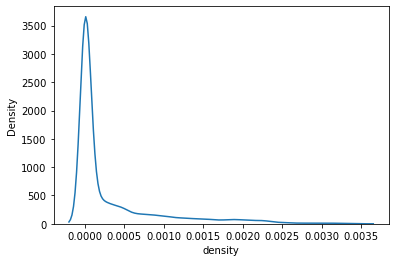

In [21]:
# Dist of density
sns.kdeplot(df.density)

## OLS

In [22]:
# Fitting normal OLS
OLS = spreg.OLS(
    # Responsive(Y)
    df.density.values,
    # Predictive(X)
    df[var_names].values,
    # var names
    name_y = "density",
    name_x = var_names
)
OLS_log = spreg.OLS(
    # Responsive(Y)
    np.log1p(df.density.values),
    # Predictive(X)
    df[var_names].values,
    # var names
    name_y = "density",
    name_x = var_names
)

In [23]:
print(OLS.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     density                Number of Observations:       54910
Mean dependent var  :      0.0003                Number of Variables   :          15
S.D. dependent var  :      0.0006                Degrees of Freedom    :       54895
R-squared           :      0.3904
Adjusted R-squared  :      0.3903
Sum squared residual:       0.012                F-statistic           :   2511.5795
Sigma-square        :       0.000                Prob(F-statistic)     :           0
S.E. of regression  :       0.000                Log likelihood        :  343044.924
Sigma-square ML     :       0.000                Akaike info criterion : -686059.849
S.E of regression ML:      0.0005                Schwarz criterion     : -685926.147

-----------------------------------------------------------------------------

In [24]:
print(OLS_log.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     density                Number of Observations:       54910
Mean dependent var  :      0.0003                Number of Variables   :          15
S.D. dependent var  :      0.0006                Degrees of Freedom    :       54895
R-squared           :      0.3904
Adjusted R-squared  :      0.3903
Sum squared residual:       0.012                F-statistic           :   2511.5286
Sigma-square        :       0.000                Prob(F-statistic)     :           0
S.E. of regression  :       0.000                Log likelihood        :  343100.094
Sigma-square ML     :       0.000                Akaike info criterion : -686170.189
S.E of regression ML:      0.0005                Schwarz criterion     : -686036.487

-----------------------------------------------------------------------------

In [26]:
# Get weight matrix
knn = weights.KNN.from_dataframe(df, k=1)

Text(0, 0.5, 'Spatial Lag of Model Residuals - $Wu$')

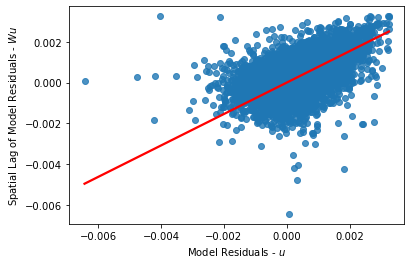

In [27]:
# Spatial Lag residual plot
lag_residual = weights.spatial_lag.lag_spatial(knn, OLS.u)
ax = sns.regplot(
    x= OLS.u.flatten(),
    y= lag_residual.flatten(),
    line_kws={"color":"red"},
    ci=None
)
ax.set_xlabel("Model Residuals - $u$")
ax.set_ylabel("Spatial Lag of Model Residuals - $Wu$")

## Spatially lagged Exogeneous Model

In [30]:
spatial = spreg.OLS(
    # Responsive(Y)
    df.density.values,
    # Predictive(X)
    df[var_names].values,
    # weight
    w = knn, 
    # var names
    name_y = "density",
    name_x = var_names,
    spat_diag=True
)

In [31]:
print(spatial.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     density                Number of Observations:       54910
Mean dependent var  :      0.0003                Number of Variables   :          15
S.D. dependent var  :      0.0006                Degrees of Freedom    :       54895
R-squared           :      0.3904
Adjusted R-squared  :      0.3903
Sum squared residual:       0.012                F-statistic           :   2511.5795
Sigma-square        :       0.000                Prob(F-statistic)     :           0
S.E. of regression  :       0.000                Log likelihood        :  343044.924
Sigma-square ML     :       0.000                Akaike info criterion : -686059.849
S.E of regression ML:      0.0005                Schwarz criterion     : -685926.147

-----------------------------------------------------------------------------